In [ ]:
# https://medium.com/@black_swan/how-to-train-word2vec-and-fasttext-embedding-on-wikipedia-corpus-9e8ac45a0c0a
# https://radimrehurek.com/gensim/auto_examples/tutorials/run_word2vec.html


In [100]:
import pandas as pd
import praw
import re
import nltk

import networkx as nx
import gensim.models
from sklearn.model_selection import train_test_split
import xgboost as xgb
import numba 
import numpy as np
import seaborn as sns

from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

In [146]:
df = pd.read_csv("../Data/wsb_cleaned.csv")


In [147]:
df = df.dropna(subset = ['title'])


Preprocessing:


In [150]:
df

,Unnamed: 0,title,author,created_datetime_utc,selftext,url,upvote_ratio,ups,total_awards_received,num_comments,num_crossposts,is_self,is_video,media_only,id,created_utc,selftext_html,author_fullname
0,0,Good time to get on $BLUE,None,2020-01-01 23:53:34,[deleted]\n,https://www.reddit.com/r/wallstreetbets/commen...,0.75,6,0,17,0,True,False,False,eipxnr,1.577923e+09,"<!-- SC_OFF --><div class=""md""><p>[deleted]</p...",NaN
1,1,i wanna buy a call but i don't want to bet too...,None,2020-01-01 23:53:28,[removed]\n,https://www.reddit.com/r/wallstreetbets/commen...,0.45,0,0,22,0,True,False,False,eipxm4,1.577923e+09,"<!-- SC_OFF --><div class=""md""><p>[removed]</p...",NaN
2,2,Buy INTU - DD,unclerudy,2020-01-01 23:50:05,https://www.schaeffersresearch.com/content/ana...,https://www.reddit.com/r/wallstreetbets/commen...,0.70,5,0,4,0,True,False,False,eipw3g,1.577923e+09,"<!-- SC_OFF --><div class=""md""><p><a href=""htt...",t2_7uwqo
3,3,"If you thought your 2019 was bad, at least you...",bd_one,2020-01-01 23:47:09,NaN,https://i.imgflip.com/3kywdh.jpg,1.00,1,0,1,0,False,False,False,eipusd,1.577922e+09,NaN,t2_13de6v
4,4,I will remember,IpMedia,2020-01-01 23:30:47,[removed]\n,https://www.reddit.com/r/wallstreetbets/commen...,0.86,11,0,4,0,True,False,False,eipn7c,1.577921e+09,"<!-- SC_OFF --><div class=""md""><p>[removed]</p...",t2_bhcyy
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1260232,960960,ASO technical breakout and DD,rldkyce,2021-05-06 00:02:57,"good evening apes, fellow smooth brains\nfirst...",https://www.reddit.com/r/wallstreetbets/commen...,0.78,44,10,54,0,True,False,False,n5udz9,1.620259e+09,"<!-- SC_OFF --><div class=""md""><p>good evening...",t2_4p2nwfnu
1260233,960961,First YOLO on CRSR,None,2021-05-06 00:02:55,[deleted]\n,https://i.redd.it/l0729o9g5ex61.png,0.57,2,0,1,0,False,False,False,n5udy3,1.620259e+09,"<!-- SC_OFF --><div class=""md""><p>[deleted]</p...",NaN
1260234,960962,Rkt to the moon!,Disastrous-Egg9959,2021-05-06 00:02:43,[removed]\n,https://www.reddit.com/r/wallstreetbets/commen...,0.48,0,0,11,0,True,False,False,n5udsv,1.620259e+09,"<!-- SC_OFF --><div class=""md""><p>[removed]</p...",t2_7hzx72of
1260235,960963,My therapist told me I’m delusional for thinki...,None,2021-05-06 00:02:38,[deleted]\n,https://i.redd.it/f2up498f5ex61.jpg,0.33,0,0,1,0,False,False,False,n5udq9,1.620259e+09,"<!-- SC_OFF --><div class=""md""><p>[deleted]</p...",NaN


In [151]:
regex = re.compile('[^a-zA-Z ]')

#@numba.jit # unfortunately this doesn't jit easily :(
def tokenize(text):
    # given a body of text, this splits into sentences, then processes each word in the sentence to remove
    # non alphabetical characters... (? bad idea, what about users with numbers in their name)
    # returns it as a list of lists of words, the format desired by gensims word2vec
    
    sentences = []
    if type(text) == str:
        for sentence in nltk.tokenize.sent_tokenize(text):
            processed = [regex.sub('', word.lower()) for word in sentence.split(' ') ]
            processed = [word for word in processed if word not in set( ['' ])]
            sentences.append(processed)
    return sentences

def average_vector(text, model):
    present_keys = [x for x in text if x in model.wv.key_to_index ]
    if not present_keys:
        return np.array([0] * len( model.wv[ model.wv.index_to_key[0]]))
    return sum( [model.wv[x] for x in present_keys] ) /len(present_keys)

def average_vector_paragraph(text, model):
    if text == []:
        return np.zeros(model.wv.vector_size)
    return sum( average_vector(sentence, model)  for sentence in text )

## Most similar posts?



import sklearn 
def similarity(vec_1, vec_2):
    return sklearn.metrics.pairwise.cosine_similarity([vec_1], [vec_2])[0]

def make_similarity_col(df, given_index):
    given_vector = df['avg_vector'][given_index] 
    df['similarity'] = df['avg_vector'].apply( lambda x : similarity(x, given_vector))
    
# helper function for printing the most similar word vectors

def sims(args, model):
    for word, sim in model.wv.most_similar(**args, topn = 10):
        print( f"{word} - similarity {sim}")
    

In [152]:
df['tokenized_title'] = df.title.apply(tokenize)
#df['tokenized_selftext'] = df.selftext.apply(tokenize)


In [156]:
def train_w2v(tokenized_text):
    # the train dataframe ot build the w2v model on
    
    corpus = []
    for tokenized in tokenized_text:
        corpus += tokenized

    model = gensim.models.Word2Vec(sentences = corpus,  min_count=10, vector_size=300, epochs = 4)
    #model_fasttext = gensim.models.FastText(sentences = corpus,  min_count=10, vector_size=200, epochs = 4)
    
    return model

def vectorize(df, model):
    df['avg_vector'] = df['tokenized_title'].apply(lambda text : average_vector_paragraph(text, model)) 
    X = np.vstack(df['avg_vector'].to_numpy())
    #df.concat(axis = 1, X)
    return X

In [ ]:
model = train_w2v(df['tokenized_title']) 

# in the final pipeline we should only do this on the train set...

# note some Weird stuff in the vocabulary:

# model.wv.key_to_index['p']

#see more with model.wv.key_to_index

In [ ]:
sims(args = {'positive': ['gme'], 'negative' : []} , model = model)

In [ ]:
# sims(args = {'positive': ['gme'], 'negative' : []} , model = model_fasttext)

In [38]:
sims(args = {'positive': ['tendies'], 'negative' : []} , model = model)

trendies - similarity 0.7260167002677917
bananas - similarity 0.6235389113426208
gains - similarity 0.6222725510597229
tenders - similarity 0.6105455756187439
monies - similarity 0.5806984901428223
profits - similarity 0.5676225423812866
chips - similarity 0.5655564665794373
crayons - similarity 0.5538128018379211
gainz - similarity 0.5533955693244934
ramen - similarity 0.5439910888671875


In [39]:
sims(args = {'positive': ['normies'], 'negative' : []} , model = model)

boomers - similarity 0.7184165120124817
shills - similarity 0.6299222707748413
algos - similarity 0.6103640794754028
redditors - similarity 0.6075345873832703
fags - similarity 0.6004220247268677
millennials - similarity 0.6000107526779175
amateurs - similarity 0.5851551294326782
trolls - similarity 0.5739937424659729
capitalists - similarity 0.5720924735069275
bots - similarity 0.5709673762321472


In [40]:
sims(args = {'positive': ['brain', 'tendies'], 'negative' : ['wrinkles']} , model = model)

gains - similarity 0.5351545810699463
profits - similarity 0.47239649295806885
gainz - similarity 0.4687989056110382
soul - similarity 0.4606021046638489
gf - similarity 0.44966116547584534
money - similarity 0.44946685433387756
bananas - similarity 0.44762393832206726
wife - similarity 0.4469150900840759
heart - similarity 0.4385174512863159
mom - similarity 0.43741828203201294


In [41]:
sims(args = {'positive': ['king', 'woman'], 'negative' : ['man']} , model = model)

overlord - similarity 0.6376240849494934
saint - similarity 0.6238170862197876
prophet - similarity 0.6131112575531006
patron - similarity 0.6117268204689026
messiah - similarity 0.6115373373031616
queen - similarity 0.606661856174469
leader - similarity 0.6021270155906677
emperor - similarity 0.594168484210968
goat - similarity 0.592577338218689
saviour - similarity 0.5735287070274353


In [42]:
sims(args = {'positive': ['lol']} , model = model)

lmao - similarity 0.7220719456672668
haha - similarity 0.5473056435585022
cuz - similarity 0.5311461687088013
wow - similarity 0.4764846861362457
kinda - similarity 0.47304728627204895
yeah - similarity 0.45775654911994934
bc - similarity 0.45566490292549133
tho - similarity 0.4429238736629486
huh - similarity 0.44158363342285156
bro - similarity 0.43773791193962097


In [43]:
## Saving and loading

import tempfile

with tempfile.NamedTemporaryFile(prefix='gensim-model-', delete=False) as tmp:
    temporary_filepath = tmp.name
    model.save(temporary_filepath)
    #
    # The model is now safely stored in the filepath.
    # You can copy it to other machines, share it with others, etc.
    #
    # To load a saved model:
    #
    new_model = gensim.models.Word2Vec.load(temporary_filepath)

Some preliminary regression /classification below -- this is slated to get moved

In [64]:
make_similarity_col(df, 0)

In [ ]:
## Question: Finding similar posts:
df_s = df.sort_values(by='similarity', ascending = False)


In [145]:
df_s

,Unnamed: 0,title,author,created_datetime_utc,selftext,url,upvote_ratio,ups,total_awards_received,num_comments,...,is_self,is_video,media_only,id,created_utc,selftext_html,author_fullname,tokenized_title,avg_vector,similarity
0,0,Good time to get on $BLUE,None,2020-01-01 23:53:34,[deleted]\n,https://www.reddit.com/r/wallstreetbets/commen...,0.75,6,0,17,...,True,False,False,eipxnr,1.577923e+09,"<!-- SC_OFF --><div class=""md""><p>[deleted]</p...",NaN,"[[good, time, to, get, on, blue]]","[-0.068030335, -0.25661317, 0.37836778, -1.168...",[0.99999994]
517223,217951,Good time to get in on bb,mhx19,2021-01-28 14:39:09,[removed]\n,https://www.reddit.com/r/wallstreetbets/commen...,1.00,1,0,0,...,True,False,False,l6y8v6,1.611845e+09,"<!-- SC_OFF --><div class=""md""><p>[removed]</p...",t2_3rrr5uk2,"[[good, time, to, get, in, on, bb]]","[0.1906106, -0.5719585, 0.53236496, -0.9956891...",[0.90678805]
1035357,736085,Good time to get in.,None,2021-02-11 17:39:04,[deleted]\n,https://i.redd.it/4otdge53xvg61.jpg,1.00,1,0,0,...,False,False,False,lhpxwp,1.613065e+09,"<!-- SC_OFF --><div class=""md""><p>[deleted]</p...",NaN,"[[good, time, to, get, in]]","[0.07077851, -0.6582309, 0.4221986, -1.264117,...",[0.90031284]
1217136,917864,$scr good time to buy on the dip,No_Notice_3818,2021-04-07 14:58:12,NaN,https://i.redd.it/6yiolflrmrr61.jpg,1.00,1,0,0,...,False,False,False,mm3ysa,1.617807e+09,NaN,t2_a1knn5vm,"[[scr, good, time, to, buy, on, the, dip]]","[-0.0084776, -0.13850585, 0.12485974, -0.61490...",[0.8249897]
583977,284705,Still a good time to get in on GME?,RedLeg5253,2021-01-29 22:03:55,[removed]\n,https://www.reddit.com/r/wallstreetbets/commen...,1.00,1,0,0,...,True,False,False,l85n83,1.611958e+09,"<!-- SC_OFF --><div class=""md""><p>[removed]</p...",t2_828u6x2c,"[[still, a, good, time, to, get, in, on, gme]]","[0.30612504, -0.57664096, 0.12011887, -1.04539...",[0.81751347]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1085752,786480,Atari SA aka PONGF,RVT1970,2021-02-22 17:57:08,[removed]\n,https://www.reddit.com/r/wallstreetbets/commen...,1.00,1,0,0,...,True,False,False,lpv129,1.614017e+09,"<!-- SC_OFF --><div class=""md""><p>[removed]</p...",t2_jc2yrtm,"[[atari, sa, aka, pongf]]","[-0.13945246, 0.11975554, -0.0068137683, 0.176...",[-0.3741174]
663043,363771,Escaped,A-Trigger,2021-01-29 05:08:17,[removed]\n,https://www.reddit.com/r/wallstreetbets/commen...,1.00,1,0,0,...,True,False,False,l7jzqg,1.611897e+09,"<!-- SC_OFF --><div class=""md""><p>[removed]</p...",t2_8mopou9h,[[escaped]],"[-0.017798865, 0.061401956, -0.016595788, 0.04...",[-0.3844504]
1213890,914618,PONGF,Excellent-Habit2886,2021-04-05 14:59:23,[removed]\n,https://www.reddit.com/r/wallstreetbets/commen...,1.00,1,0,0,...,True,False,False,mkmnii,1.617635e+09,"<!-- SC_OFF --><div class=""md""><p>[removed]</p...",t2_7aq7ly1n,[[pongf]],"[-0.02055906, -0.08854937, 0.041225538, 0.1137...",[-0.39948618]
1249826,950554,$PONGF,GoogetyBlamBamShazam,2021-04-30 16:17:19,[removed]\n,https://www.reddit.com/r/wallstreetbets/commen...,1.00,1,0,0,...,True,False,False,n1xbbd,1.619799e+09,"<!-- SC_OFF --><div class=""md""><p>[removed]</p...",t2_9z4jxqam,[[pongf]],"[-0.02055906, -0.08854937, 0.041225538, 0.1137...",[-0.39948618]


In [70]:
## Trying clustering:

df_popular = df[ df.ups >= 5000]
X = np.vstack(df_popular['avg_vector'].to_numpy())
#model = KMeans(n_clusters=5)
#model.fit(X)
#df_popular['prediction'] = model.predict(X)
clustering = SpectralClustering(n_clusters = 2).fit(X)
df_popular['prediction'] = clustering.labels_

sns.scatterplot(data = df_popular, x = 'prediction', y = 'ups')
df_popular[df_popular.prediction == 1]

In [157]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 10)

935262     222
416369       1
382858      18
884008       1
761128       1
          ... 
1114747      4
408280       2
888239       1
1010336      1
508714       3
Name: ups, Length: 252048, dtype: int64

In [158]:
from sklearn.metrics import mean_squared_error

# Instantiate an XGBRegressor
xgr = xgb.XGBRegressor(random_state=2)

# Fit the classifier to the training set
xgr.fit(X_train, y_train)

y_pred = xgr.predict(X_test)

mean_squared_error(y_test, y_pred)

3516449.6186454897

<AxesSubplot:xlabel='0', ylabel='1'>

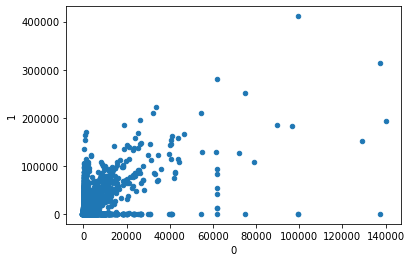

In [181]:
plot = pd.DataFrame([xgr.predict(X_train), y_train])
plot.transpose().plot(kind = 'scatter', x = 0, y = 1)

In [100]:

plot = pd.DataFrame([y_pred, y_test])

<AxesSubplot:xlabel='0', ylabel='1'>

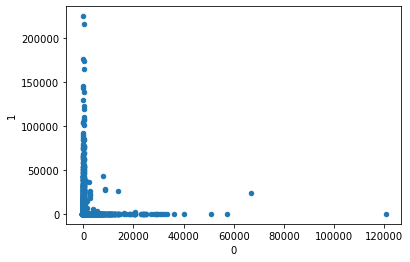

In [159]:
plot.transpose().plot(kind = 'scatter', x = 0, y = 1)

In [165]:

output = pd.DataFrame(y_test)
output['pred'] = y_pred

In [171]:
df_with_pred = df.merge(output, right_index = True, left_index = True)

In [174]:
df_with_pred.sort_values(by = 'pred', ascending = False)

,Unnamed: 0,title,author,created_datetime_utc,selftext,url,upvote_ratio,ups_x,total_awards_received,num_comments,...,is_video,media_only,id,created_utc,selftext_html,author_fullname,avg_vector,similarity,ups_y,pred
774020,474748,forever never dies,none,2021-01-31 11:31:38,deleted,https://i.redd.it/sx08zn1rlne61.jpg,1.00,1,0,0,...,False,False,l9altm,1.612093e+09,"<!-- SC_OFF --><div class=""md""><p>[deleted]</p...",NaN,"[1.5393746, -0.68029225, 0.18800707, -0.732837...",[0.88995945],1,129129.296875
718454,419182,welcome to the endgame,none,2021-01-30 13:44:11,deleted,https://streamable.com/4lol9t,0.67,1,0,1,...,False,False,l8lz44,1.612014e+09,"<!-- SC_OFF --><div class=""md""><p>[deleted]</p...",NaN,"[1.9341128, -0.7926674, 0.44564953, -0.469884,...",[0.9575975],1,72273.195312
314392,15120,gme yolo update jan,deepfuckingvalue,2021-01-14 21:03:13,nan,https://i.redd.it/dxc04m314db61.png,0.97,24255,197,1604,...,False,False,kxeq23,1.610658e+09,NaN,t2_49l8qytq,"[1.7628586, -0.56726193, 0.45402333, -0.575014...",[0.9313593],24255,61682.039062
843826,544554,there is no silver short squeeze happening non...,majestichandle,2021-02-01 13:51:03,removed,https://www.reddit.com/r/wallstreetbets/commen...,1.00,1,0,0,...,False,False,la3h37,1.612187e+09,"<!-- SC_OFF --><div class=""md""><p>[removed]</p...",t2_84feq39m,"[1.6771866, -0.7346322, 0.17244963, -0.5704492...",[0.92732203],1,42207.101562
821281,522009,there is no silver short squeeze happening non...,onboarding,2021-02-01 17:39:36,nan,https://www.reddit.com/r/wallstreetbets/commen...,1.00,1,0,0,...,False,False,la8z3w,1.612201e+09,NaN,t2_9yc6gs88,"[1.6771866, -0.7346322, 0.17244963, -0.5704492...",[0.92732203],1,42207.101562
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1066640,767368,sxc,kenmeansyes,2021-02-17 19:40:13,nan,https://i.redd.it/s2trq6x9c3i61.png,1.00,1,0,0,...,False,False,lm2r9k,1.613591e+09,NaN,t2_a0sm1gqq,"[2.028814, -0.38747144, 0.21785854, 0.03631463...",[0.51870126],1,-689.110535
502441,203169,rrc,researcherfunny,2021-01-28 15:24:10,removed,https://www.reddit.com/r/wallstreetbets/commen...,0.33,0,0,0,...,False,False,l6zkcp,1.611847e+09,"<!-- SC_OFF --><div class=""md""><p>[removed]</p...",t2_8a8rusi5,"[1.6028289, -0.21937473, -0.689915, -0.7976985...",[0.5677874],0,-812.436401
48972,48972,futures uuupppppp for now,controlplusz,2020-03-09 23:07:06,nan,https://www.cnbc.com/2020/03/09/dow-futures-fa...,0.93,99,0,187,...,False,False,fg3srd,1.583795e+09,NaN,t2_4ewo25vb,"[1.9678787, -0.27154619, -0.14154428, -0.58761...",[0.7364304],99,-850.473877
1157222,857950,no funds no fun,none,2021-03-09 02:15:16,deleted,https://i.redd.it/gkqumqq7wwl61.jpg,1.00,1,0,0,...,False,False,m0wd33,1.615256e+09,"<!-- SC_OFF --><div class=""md""><p>[deleted]</p...",NaN,"[1.5684566, -0.514331, -0.51395595, -0.6512546...",[0.82205725],1,-1022.922180


In [176]:
df['pred'] = xgr.predict( np.vstack(df['avg_vector'].to_numpy()))

<AxesSubplot:xlabel='ups', ylabel='pred'>

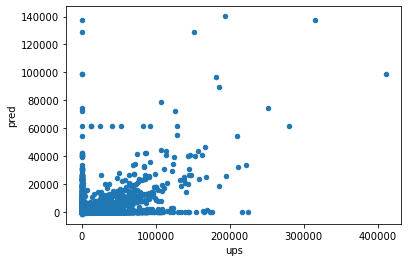

In [180]:
df.plot(kind = 'scatter', x = 'ups', y = 'pred')

In [185]:
df.selftext[4]

'removed'